<a href="https://colab.research.google.com/github/will-hill/Yelp_NLP/blob/master/3.Basic_Keras_DL_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Keras Deep Learning NLP
inspired from 
* https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras
* https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-regression-ceee5a9eadff


### Will's Setup Code
I created a couple subdirectories in my Google Drive

In [0]:
# LAB
# REVIEW_FILE_JSON = 'review.json' 
# COLAB
# REVIEW_FILE_JSON = '/content/drive/My Drive/colab/yelp_nlp/review.json'

### Colab Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Joanna Setup Code

In [3]:
from google.colab import drive #python code
drive.mount('/content/drive') # python code <- follow the resulting directions
!ln -s drive/My\ Drive data # bash command
!ls # you should "see" drive directory now.
hd5_path='data/final_project_dl/reviews_100000.h5'
#!pip install numpy==1.15.4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link 'data/My Drive': Function not implemented
data  drive  sample_data


In [0]:
import pandas as pd
df = pd.read_hdf(hd5_path)

## Balancing Dataset

In [5]:
df=df[df.stars!=3]
df.stars.value_counts()

5.0    44367
4.0    22103
1.0    14585
2.0     7975
Name: stars, dtype: int64

In [6]:
df.stars = pd.cut(df.stars.fillna(0), bins=[0,2,max(df.stars)+1], labels=['Negative','Positive'])
min_bucket=min(df.stars.value_counts())
df.stars.value_counts()

Positive    66470
Negative    22560
Name: stars, dtype: int64

In [0]:
import numpy as np

final_indices = []
for category in set(df.stars):
  indices=df[df.stars == category].index
  random_indices =  list(np.random.choice(indices,min_bucket,replace=False))
  final_indices += random_indices
  

In [8]:
df = df.loc[final_indices]
#df=df.sample(n=10000)
df.stars.value_counts()


Positive    22560
Negative    22560
Name: stars, dtype: int64

### create word index

In [0]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# From https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [0]:
df['text']=df['text'].apply(text_to_wordlist)

In [11]:
df['text'].head()

49776    island grocery and carribean restaurant is sma...
2623     excellent customer service was able to schedul...
28725    this is how i like to party loud dancey music ...
28844    my boyfriend and i recently had a couples mass...
17254    without a doubt i think i would have to say th...
Name: text, dtype: object

In [12]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'].values)
VOCAB_SIZE = len(tokenizer.word_index) + 1
del Tokenizer

Using TensorFlow backend.


In [13]:
VOCAB_SIZE

53663

### convert words to indices

In [0]:
X = tokenizer.texts_to_sequences(df.text.values)
del tokenizer

### add zeroes so all texts are same length

In [0]:
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X)
del pad_sequences

# Y/N Useful

In [16]:
# Mark as Useful if at least 1 "Useful" upvote. Else 0.
#Y_useful_binary = df.stars
Y_useful_binary = pd.get_dummies(df['stars']).values

from sklearn.model_selection import train_test_split

X_train_useful_binary, X_test_useful_binary, Y_train_useful_binary, Y_test_useful_binary = train_test_split(X,Y_useful_binary, test_size = 0.33, random_state = 42)
print(X_train_useful_binary.shape,Y_train_useful_binary.shape)
print(X_test_useful_binary.shape,Y_test_useful_binary.shape)

del train_test_split

(30230, 1012) (30230, 2)
(14890, 1012) (14890, 2)


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D
from keras import regularizers 

OUTPUT_DIM = 64 
LSTM_OUT = 64 

model_useful_binary = Sequential()
model_useful_binary.add(Embedding(VOCAB_SIZE, 
                    OUTPUT_DIM, 
                    mask_zero=True,
                    input_length = X_train_useful_binary.shape[1]))

model_useful_binary.add(Dropout(0.5))

model_useful_binary.add(LSTM(LSTM_OUT,
               dropout=0.4,
               recurrent_dropout=0.4,
               return_sequences=True,
               kernel_regularizer=regularizers.l2(0.01)))

model_useful_binary.add(LSTM(int(LSTM_OUT/2.0),
               dropout=0.5,
               recurrent_dropout=0.5,
               return_sequences=False,
               kernel_regularizer=regularizers.l2(0.01)))

model_useful_binary.add(Dropout(0.5))

model_useful_binary.add(Dense(8))
model_useful_binary.add(Dense(2,activation='sigmoid'))

model_useful_binary.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['mse','accuracy'])
print(model_useful_binary.summary())


W0805 02:33:59.057010 140557951776640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 02:33:59.091647 140557951776640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 02:33:59.097200 140557951776640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 02:33:59.116124 140557951776640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0805 02:33:59.127604 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1012, 64)          3434432   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1012, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1012, 64)          33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total para

In [18]:
%%time
batch_size = 256
epochs = 10
history_useful_binary = model_useful_binary.fit(X_train_useful_binary, Y_train_useful_binary, validation_split=0.333, epochs = epochs, batch_size=batch_size, verbose = 2)

Train on 20163 samples, validate on 10067 samples
Epoch 1/10
 - 405s - loss: 1.6017 - mean_squared_error: 0.2401 - acc: 0.5760 - val_loss: 0.8567 - val_mean_squared_error: 0.1654 - val_acc: 0.8232
Epoch 2/10
 - 400s - loss: 0.6495 - mean_squared_error: 0.1414 - acc: 0.8338 - val_loss: 0.3813 - val_mean_squared_error: 0.0785 - val_acc: 0.9035
Epoch 3/10
 - 403s - loss: 0.4162 - mean_squared_error: 0.0953 - acc: 0.8875 - val_loss: 0.3040 - val_mean_squared_error: 0.0671 - val_acc: 0.9155
Epoch 4/10
 - 403s - loss: 0.3481 - mean_squared_error: 0.0787 - acc: 0.9078 - val_loss: 0.2892 - val_mean_squared_error: 0.0654 - val_acc: 0.9165
Epoch 5/10
 - 404s - loss: 0.2869 - mean_squared_error: 0.0626 - acc: 0.9256 - val_loss: 0.2819 - val_mean_squared_error: 0.0684 - val_acc: 0.9076
Epoch 6/10
 - 411s - loss: 0.2638 - mean_squared_error: 0.0577 - acc: 0.9304 - val_loss: 0.2977 - val_mean_squared_error: 0.0728 - val_acc: 0.9024
Epoch 7/10
 - 392s - loss: 0.2579 - mean_squared_error: 0.0557 - acc

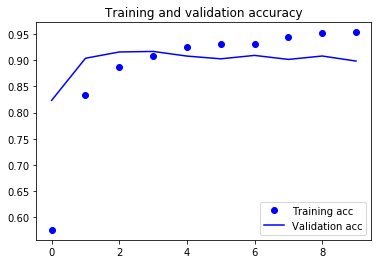

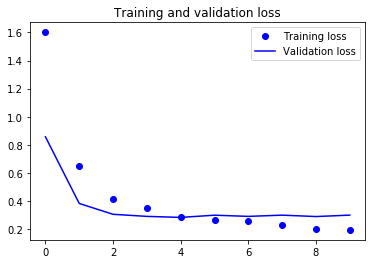

In [19]:
import matplotlib.pyplot as plt 
acc = history_useful_binary.history['acc']

val_acc = history_useful_binary.history['val_acc']
loss = history_useful_binary.history['loss']
val_loss = history_useful_binary.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
loss_ub, mse_ub, acc_ub = model_useful_binary.evaluate(X_test_useful_binary, Y_test_useful_binary, verbose = 2, batch_size = batch_size)

In [21]:
print(loss_ub) #binary cross entropy
print(mse_ub)
print(acc_ub)

0.28468006854092537
0.07187130984601917
0.9035594358069533


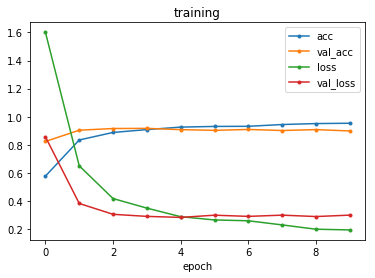

In [22]:
import matplotlib.pyplot as plt

plt.plot(history_useful_binary.history['acc'], '.-')
plt.plot(history_useful_binary.history['val_acc'], '.-')
plt.plot(history_useful_binary.history['loss'], '.-')
plt.plot(history_useful_binary.history['val_loss'], '.-')

plt.title('training')
plt.xlabel('epoch')
plt.legend(['acc','val_acc','loss','val_loss'], loc='best')

del plt

In [0]:
y_pred = model_useful_binary.predict(X_test_useful_binary[0:200])


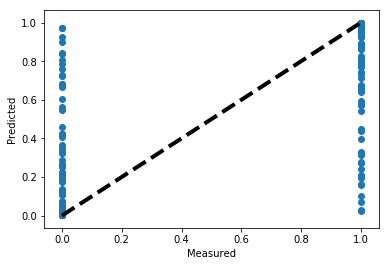

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Y_test_useful_binary[0:200], y_pred)
ax.plot([Y_test_useful_binary[0:200].min(), Y_test_useful_binary[0:200].max()], [Y_test_useful_binary[0:200].min(), Y_test_useful_binary[0:200].max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()